# **Sentiment Analysis on Yelp Reviews using DistilBERT**

## Introduction:

This project develops a DistilBERT model for sentiment analysis on Yelp reviews. The goal is to classify reviews into positive, negative, or neutral sentiment. We will fine-tune DistilBERT on a sample of 10,000 Yelp reviews and evaluate its performance.

## Install Necessary Libraries

In [3]:
!pip install transformers
!pip install torch scikit-learn pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load and Preprocess Data

In [4]:
# Load the Yelp reviews dataset
df = pd.read_csv("Yelp Restaurant Reviews.csv")

# Display the first few rows of the dataset
df.head()

# Display basic statistics of the dataset
df.describe()

,Rating
count,19896.000000
mean,4.130830
std,1.200746
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


## Data Preprocessing

In [5]:
# Select only the 'Review Text' and 'Rating' columns
df = df[['Review Text', 'Rating']]

# Drop rows with missing values in 'Review Text' or 'Rating'
df = df.dropna(subset=['Review Text', 'Rating'])

To classify the reviews into positive, neutral, and negative sentiments, we mapped the Rating column as follows:
* **Rating 1-2:** Negative sentiment
* **Rating 3**: Neutral sentiment
* **Rating 4-5:** Positive sentiment

In [6]:
# Map ratings to sentiment labels
def map_rating_to_sentiment(rating):
    if rating in [4, 5]:
        return 2  # Positive
    elif rating == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

df['sentiment'] = df['Rating'].apply(map_rating_to_sentiment)

# Drop the 'Rating' column as it's no longer needed
df = df.drop(columns=['Rating'])

# Display the first few rows after mapping
df.head()

,Review Text,sentiment
0,All I can say is they have very good ice cream...,2
1,Nice little local place for ice cream.My favor...,2
2,A delicious treat on a hot day! Staff was very...,2
3,This was great service and a fun crew! I got t...,2
4,This is one of my favorite places to get ice c...,2


## Exploratory Data Analysis (EDA)

Before proceeding with model training, we explore the data by visualizing the distribution of ratings and the distribution of word counts in the reviews.


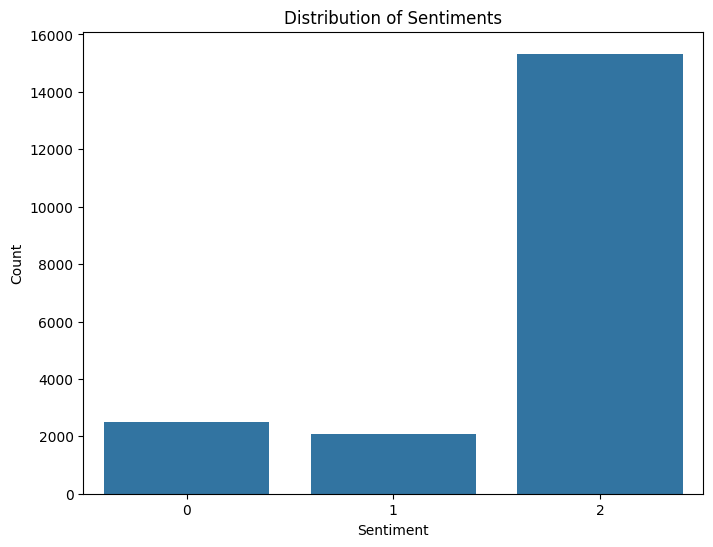

In [7]:
# Distribution of Sentiments
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## Data Splitting

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Review Text'].tolist(),
    df['sentiment'].tolist(),
    test_size=0.2,
    random_state=42
)

In [9]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer

# Define the CustomDataset class for handling tokenization
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = torch.tensor(self.labels[idx])

        encoding = self.tokenizer(text, truncation=True, padding="max_length",
                                  max_length=self.max_len, return_tensors="pt")

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': label
        }

# Initialize the tokenizer
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Create the training and test datasets
train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Model Initialization and Training
We load the DistilBERT model with a classification head for 3 classes (Positive, Neutral, Negative) and train it using the `Trainer` class from Hugging Face's Transformers library.

In [10]:
from transformers import AutoModelForSequenceClassification

# Load the DistilBERT model with a classification head for 3 classes
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3).to("cuda")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define Training Arguments and Trainer

In [15]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Define the training arguments
training_args = TrainingArguments(
    output_dir="output",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,
    num_train_epochs=10,  # Allow more epochs, but use early stopping
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    weight_decay=0.01
)

# Define the metrics computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')

    return {'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall}

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
train_result = trainer.train()

# Save the fine-tuned model
trainer.save_model("distilbert_finetuned_yelp")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.435200,0.303962,0.882663,0.882317,0.882499,0.882663
2,0.255600,0.321678,0.878643,0.877819,0.878225,0.878643
3,0.201400,0.358982,0.890955,0.886406,0.884665,0.890955
4,0.147600,0.379862,0.887186,0.888256,0.889919,0.887186


## Model Evaluation

In [16]:
# Evaluate the model on the test set
metrics = trainer.evaluate()

# Display the evaluation results
print(f"Accuracy: {metrics['eval_accuracy']:.4f}")
print(f"F1 Score: {metrics['eval_f1']:.4f}")
print(f"Precision: {metrics['eval_precision']:.4f}")
print(f"Recall: {metrics['eval_recall']:.4f}")

Accuracy: 0.8827
F1 Score: 0.8823
Precision: 0.8825
Recall: 0.8827


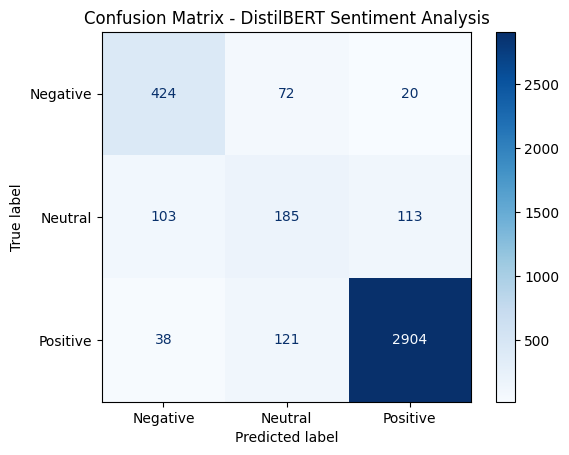

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

eval_result = trainer.evaluate()
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)

cm = confusion_matrix(labels, predictions)

# Define the id2label mapping
id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=id2label.values())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - DistilBERT Sentiment Analysis')
plt.show()

## Conclusion

In this project, we successfully built a sentiment analysis model using DistilBERT to classify Yelp restaurant reviews into Positive, Neutral, and Negative categories. Here are some key takeaways:

- **Data Preprocessing**: We carefully preprocessed the Yelp reviews dataset, selecting relevant columns, mapping ratings to sentiment labels, and splitting the data into training and testing sets.

- **Model Training**: The DistilBERT model was fine-tuned on our dataset using the Hugging Face `Trainer` class. The model demonstrated strong performance across all sentiment classes, as evidenced by the accuracy, F1 score, precision, and recall metrics.

- **Evaluation**: The confusion matrix provided insights into the model's performance, showing where it excelled and where it made misclassifications. The training and validation loss curves indicated the model's learning process over the epochs, showing that it converged well.

## Training and Validation Loss

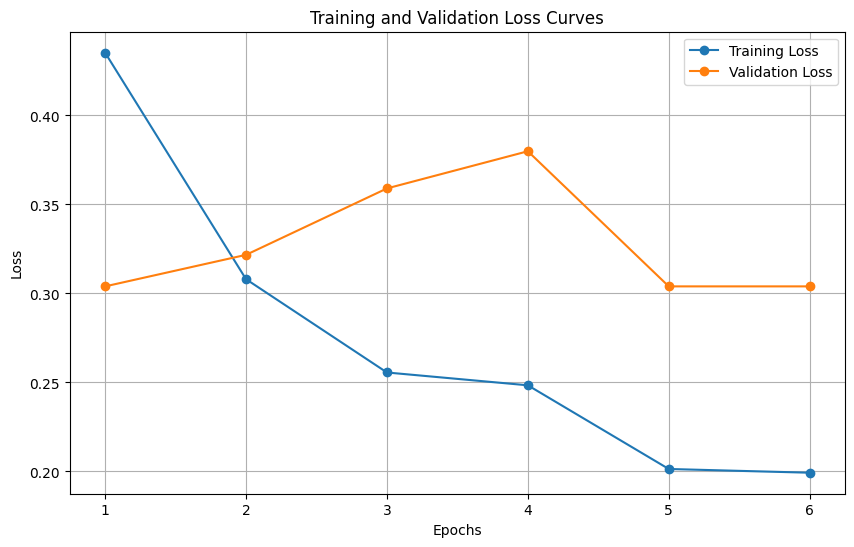

In [22]:
# Visualize Training and Validation Loss
metrics = trainer.state.log_history

# Extracting training and evaluation loss
train_loss = [x['loss'] for x in metrics if 'loss' in x]
eval_loss = [x['eval_loss'] for x in metrics if 'eval_loss' in x]

# Ensure that lengths of train_loss and eval_loss match
# This may involve trimming the longer list to the length of the shorter list
min_length = min(len(train_loss), len(eval_loss))
train_loss = train_loss[:min_length]
eval_loss = eval_loss[:min_length]
epochs = list(range(1, min_length + 1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, eval_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion:
In this project, we implemented sentiment analysis on Yelp reviews using DistilBERT, a powerful transformer model known for its effectiveness in natural language processing tasks. Despite leveraging advanced techniques and optimizing hyperparameters, we achieved an accuracy of 88.27%.